In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from skorch.regressor import NeuralNetRegressor

In [55]:
df = pd.read_pickle('./data/simple_train.pkl')

In [56]:
class SimpleMLP(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(3 + 16, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)
    
    def forward(self, X_numeric, X_categorical1):
        X = torch.cat([X_numeric, self.emb1(X_categorical1).squeeze()], 1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        return self.fc4(X)

In [57]:
model = NeuralNetRegressor(SimpleMLP,
                           max_epochs=25,
                           lr=0.01,
                           optimizer=torch.optim.Adam)

In [58]:
model.fit({'X_numeric': df[['x1', 'x2', 'x4']].values,
           'X_categorical1': df[['x3']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.3469        0.3137  0.1364
      2        0.3112        0.2911  0.1369
      3        0.2656        0.2805  0.1320
      4        0.2227        0.2281  0.1327
      5        0.3174        0.3213  0.1329
      6        0.3354        0.3532  0.1324
      7        0.3129        0.2729  0.1328
      8        0.2420        0.2265  0.1368
      9        0.1482        0.1953  0.1426
     10        0.1815        0.2164  0.1313
     11        0.1758        0.1284  0.1307
     12        0.1443        0.1462  0.1297
     13        0.0999        0.1533  0.1318
     14        0.0744        0.1009  0.1330
     15        0.0795        0.0834  0.1377
     16        0.0976        0.2821  0.1352
     17        0.1278        0.1538  0.1302
     18        0.1521        0.1083  0.1349
     19        0.0716        0.1020  0.1306
     20        0.0501        0.1032  0.1386
     21        0.0374        0.0

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=SimpleMLP(
    (emb1): Embedding(50, 16)
    (fc1): Linear(in_features=19, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=32, bias=True)
    (fc4): Linear(in_features=32, out_features=1, bias=True)
  ),
)

In [59]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [60]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_numeric': dfc[['x1', 'x2', 'x4']].values,
                       'X_categorical1': dfc[['x3']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

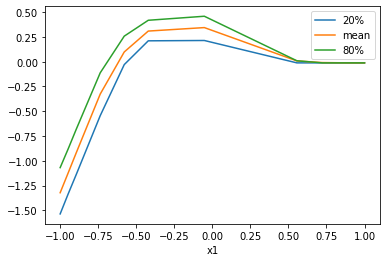

In [61]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()